### DCGAN (Deep Convolutional Generative Adversarial Network)

Reference - https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('fashion-mnist_train.csv')
train = train.iloc[:10000]

In [3]:
print (train.shape)

(10000, 785)


In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## normalize and reshape the predictors  
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=123)

In [7]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [31]:
# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 200

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

# number of workers in data loader
workers = 1

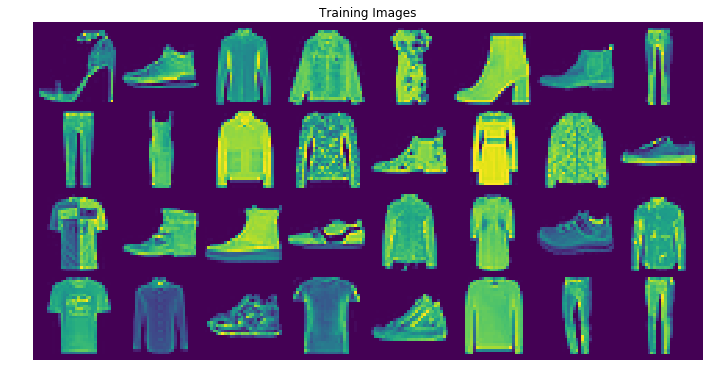

In [32]:
dataloader = torch.utils.data.DataLoader(train_x.reshape(train_x.shape[0],nc,image_size,image_size), batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(vutils.make_grid(real_batch.to(device), padding=2, normalize=True).cpu()[0,:,:])
plt.show()

In [33]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [34]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            #nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            #nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
#netG = netG.double()

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(200, 224, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(56, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
)


In [35]:
import torchsummary

In [37]:
torchsummary.summary(input_size=(nz,1,1,),model=netG)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 224, 4, 4]         716,800
       BatchNorm2d-2            [-1, 224, 4, 4]             448
              ReLU-3            [-1, 224, 4, 4]               0
   ConvTranspose2d-4            [-1, 112, 7, 7]         401,408
       BatchNorm2d-5            [-1, 112, 7, 7]             224
              ReLU-6            [-1, 112, 7, 7]               0
   ConvTranspose2d-7           [-1, 56, 14, 14]         100,352
       BatchNorm2d-8           [-1, 56, 14, 14]             112
              ReLU-9           [-1, 56, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             896
      BatchNorm2d-11            [-1, 1, 28, 28]               2
             ReLU-12            [-1, 1, 28, 28]               0
Total params: 1,220,242
Trainable params: 1,220,242
Non-trainable params: 0
---------------------------

In [38]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            #nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 2),
            #nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
#netD = netD.double()

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(28, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(112, 224, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(224, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [39]:
torchsummary.summary(input_size=(1,28,28,),model=netD)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 14, 14]             448
         LeakyReLU-2           [-1, 28, 14, 14]               0
            Conv2d-3            [-1, 112, 7, 7]          50,176
       BatchNorm2d-4            [-1, 112, 7, 7]             224
         LeakyReLU-5            [-1, 112, 7, 7]               0
            Conv2d-6            [-1, 224, 4, 4]         401,408
       BatchNorm2d-7            [-1, 224, 4, 4]             448
         LeakyReLU-8            [-1, 224, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           3,584
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 456,288
Trainable params: 456,288
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 1.74
Estimated T

In [40]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [41]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.float().to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/250]	Loss_D: 1.4187	Loss_G: 1.7718	D(x): 0.6787	D(G(z)): 0.5914 / 0.1906
[0/5][50/250]	Loss_D: 0.1974	Loss_G: 5.1325	D(x): 0.8879	D(G(z)): 0.0654 / 0.0091
[0/5][100/250]	Loss_D: 0.1766	Loss_G: 5.5621	D(x): 0.8753	D(G(z)): 0.0314 / 0.0053
[0/5][150/250]	Loss_D: 0.1094	Loss_G: 5.9879	D(x): 0.9421	D(G(z)): 0.0466 / 0.0037
[0/5][200/250]	Loss_D: 0.5779	Loss_G: 4.7922	D(x): 0.7785	D(G(z)): 0.2076 / 0.0137
[1/5][0/250]	Loss_D: 0.1610	Loss_G: 4.1958	D(x): 0.9552	D(G(z)): 0.1017 / 0.0242
[1/5][50/250]	Loss_D: 0.2590	Loss_G: 4.7402	D(x): 0.9184	D(G(z)): 0.1395 / 0.0197
[1/5][100/250]	Loss_D: 0.1863	Loss_G: 3.5834	D(x): 0.9103	D(G(z)): 0.0697 / 0.0438
[1/5][150/250]	Loss_D: 0.3073	Loss_G: 3.5701	D(x): 0.8826	D(G(z)): 0.1451 / 0.0389
[1/5][200/250]	Loss_D: 0.3309	Loss_G: 2.9241	D(x): 0.8897	D(G(z)): 0.1534 / 0.0770
[2/5][0/250]	Loss_D: 0.4553	Loss_G: 4.3677	D(x): 0.8613	D(G(z)): 0.2153 / 0.0231
[2/5][50/250]	Loss_D: 0.5757	Loss_G: 3.2571	D(x): 0.8113	D(G(z)): 0.2

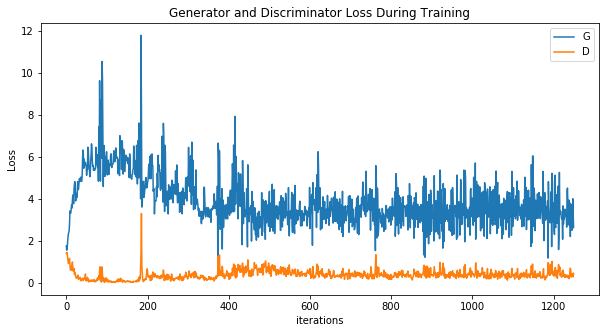

In [42]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

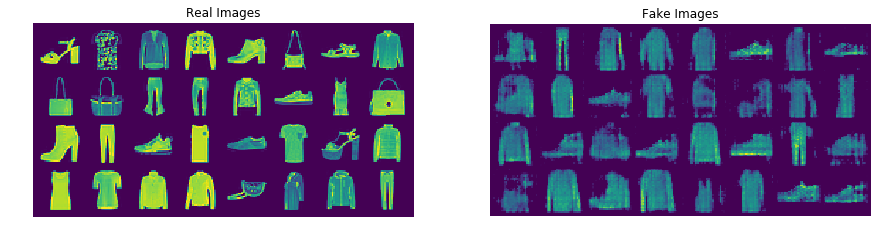

In [43]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")

plt.imshow(vutils.make_grid(real_batch.to(device), padding=5, normalize=True).cpu()[0,:,:])

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(img_list[-1][0,:,:])
plt.show()